# **Install Spark**

In [ ]:
!pip3 -q install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


# **Install pyvi**

In [ ]:
!pip install pyvi

# **Install WordCloud**

In [ ]:
!pip install wordcloud

# **Import Libraries**

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, udf
from pyspark.sql.types import BooleanType
from pyspark.sql.types import StringType
from pyspark.sql import SparkSession
from pyspark.sql.functions import lower, regexp_replace
from pyspark.sql.functions import explode, split
from pyspark.sql.functions import desc
from pyspark.sql.functions import concat_ws

In [ ]:
import re
from pyvi import ViTokenizer
from wordcloud import WordCloud, STOPWORDS
from operator import add
import numpy as np  # useful for many scientific computing in Python
import pandas as pd # primary data structure library
from PIL import Image # converting images into arrays
import matplotlib.pyplot as plt
import altair as alt
import seaborn as sns

%matplotlib inline

In [ ]:
spark = SparkSession.builder \
    .appName("ReadCSVExample") \
    .getOrCreate()

# **Import Data**

**File Bình luận**

In [ ]:
!pip install gdown
import gdown

file_url = "https://drive.google.com/uc?id=1j2GdUcs7aZx14qyQuRcfs2JXyXYWf8VJ"
output = "/content/200k_comments.csv"

# Tải file về
gdown.download(file_url, output, quiet=False)

# Đọc dữ liệu từ file CSV
csv_data = spark.read.csv(output, header=True, inferSchema=True)

csv_data.show(5, truncate=False)

Downloading...
From: https://drive.google.com/uc?id=1j2GdUcs7aZx14qyQuRcfs2JXyXYWf8VJ
To: /content/200k_comments.csv
100%|██████████| 38.2M/38.2M [00:00<00:00, 71.9MB/s]


+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------------------------------------------------+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+
|comments                                                                                                                                                                    |_c1                                                    |_c2 |_c3 |_c4 |_c5 |_c6 |_c7 |_c8 |_c9 |_c10|_c11|_c12|_c13

**Xử lý cột 'comments'**

In [ ]:
# Lấy danh sách các cột
columns = csv_data.columns

# Danh sách các cột trừ cột 'comments'
columns = [col for col in csv_data.columns if col != 'comments']

# Gộp các giá trị từ các cột còn lại vào cột 'comments'
csv_data = csv_data.withColumn('comments', concat_ws(' ', col('comments'), *[col(c) for c in columns]))

# Chỉ giữ lại cột 'comments'
csv_data = csv_data.select('comments')

# Hiển thị một vài dòng của DataFrame mới để kiểm tra
csv_data.show(5)

+--------------------+
|            comments|
+--------------------+
|Thương chị !!!!! ...|
|  Chuẩn rồi a tin em|
|End of season sal...|
|Kiện bằng mọi giá...|
|úi có anh phóng v...|
+--------------------+
only showing top 5 rows



**File Từ toxic**

In [ ]:
!gdown --id 1bd0lAUf3EelR2GSXLAVrjbFQLuxT2R4z

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1bd0lAUf3EelR2GSXLAVrjbFQLuxT2R4z
To: /content/toxicword.txt
100% 4.49k/4.49k [00:00<00:00, 13.7MB/s]


# **Tiền xử lý dữ liệu**

In [ ]:
# Chuyển đổi DataFrame thành RDD
rdd = csv_data.rdd

# Chuyển đổi các hàng thành chuỗi văn bản
textRDD = rdd.map(lambda row: ",".join([str(elem) for elem in row]))

In [ ]:
textRDD.take(5)

['Thương chị !!!!! Em tin chị !!!! Cảm ơn chị !!! Chúc vợ chồng anh chị thật nhiều sức khỏe !!!!! Những người phá hoại họ sẽ bị trừng phạt thôi. Trả lại bình yên cho xã hội .',
 'Chuẩn rồi a tin em',
 'End of season sale giảm 70% anh em ơi',
 'Kiện bằng mọi giá. Cho những kẻ vu khống bôi nhọ danh dự người khác một cách cảm tính  vô căn cứ và vô lương tâm phải trả giá đúng luật pháp.',
 'úi có anh phóng viên đội nón Jockey thì phải']

In [ ]:
# Xóa đi các dấu cách thừa, các từ không cần thiết cho việc phân loại văn bản
def chuan_hoa_cau(textRDD):
    textRDD = re.sub(r'[^\s\wáàảãạăắằẳẵặâấầẩẫậéèẻẽẹêếềểễệóòỏõọôốồổỗộơớờởỡợíìỉĩịúùủũụưứừửữựýỳỷỹỵđ_]',' ',textRDD)
    textRDD = re.sub(r'\s+', ' ', textRDD).strip()
    return textRDD

# Tách từ tiếng việt, từ tiếng việt không giống như tiếng anh, tách từ tiếng anh ta chỉ cần tách bằng khoảng trắng
def tach_tu_tieng_viet(textRDD):
    textRDD = ViTokenizer.tokenize(textRDD)
    return textRDD

def tien_xu_li(textRDD):
    textRDD = tach_tu_tieng_viet(textRDD)
    textRDD = chuan_hoa_cau(textRDD)
    return textRDD

In [ ]:
textRDD2 = textRDD.map(tien_xu_li)
textRDD2.take(10)

['Thương chị Em tin chị Cảm_ơn chị Chúc vợ_chồng anh_chị thật nhiều sức_khỏe Những người phá_hoại họ sẽ bị trừng_phạt thôi Trả lại bình_yên cho xã_hội',
 'Chuẩn rồi a tin em',
 'End of season sale giảm 70 anh_em ơi',
 'Kiện bằng mọi giá Cho những kẻ vu_khống bôi_nhọ danh_dự người khác một_cách cảm_tính vô căn_cứ và vô_lương_tâm phải trả_giá đúng luật_pháp',
 'úi có anh phóng_viên đội nón Jockey thì phải',
 'Hú_hú',
 'ĐỂ MỘT NGƯỜI NÓI THÔI ANH CHỊ TRANH NHAU NÓI_KHÓ HIỂU QUÁAAAAAAAA ANH VINH TO_TIẾNG QUÁ SAO LẠI MẮNG NGƯỜI XEM THẾ ANH ƠI NGHE ANH NÓI MÀ EM SẮP KHÓC RỒI',
 'Anh_chị coi live mỏi_mắt qua Jockey lựa đồ nhe Bên mình đang giảm 70 lận ó',
 'Bên em có DẦU_GỘI PHỦ BẠC a Vinh mua gội cho đỡ bạc tóc nha a Chứ 2light quá rồi',
 'Xếp_hàng không chen_lấn cả nhà']

# **Trực quan hóa dữ liệu**

**WordCount**

In [ ]:
def tokenize2(textRDD2):
    return textRDD2.split()

In [ ]:
wordsRDD = textRDD2.flatMap(tokenize2)

print(wordsRDD)
wordsRDD.take(10)

PythonRDD[26] at RDD at PythonRDD.scala:53


['Thương',
 'chị',
 'Em',
 'tin',
 'chị',
 'Cảm_ơn',
 'chị',
 'Chúc',
 'vợ_chồng',
 'anh_chị']

In [ ]:
wc = wordsRDD.map(lambda x: (x,1))
counts = wc.reduceByKey(add)

counts.take(10)

[('Em', 3997),
 ('Cảm_ơn', 2265),
 ('Chúc', 6670),
 ('vợ_chồng', 2573),
 ('thật', 5865),
 ('nhiều', 11810),
 ('sức_khỏe', 3473),
 ('họ', 3119),
 ('Trả', 67),
 ('xã_hội', 467)]

In [ ]:
# Chuyển đổi RDD thành DataFrame với schema là ('word', 'count')
counts_df = counts.toDF(["word", "count"])

# Hiển thị DataFrame mới
counts_df.show()

+--------+-----+
|    word|count|
+--------+-----+
|      Em| 3997|
|  Cảm_ơn| 2265|
|    Chúc| 6670|
|vợ_chồng| 2573|
|    thật| 5865|
|   nhiều|11810|
|sức_khỏe| 3473|
|      họ| 3119|
|     Trả|   67|
|  xã_hội|  467|
|      em|19585|
|     End|    1|
|      of|   27|
|    sale|  165|
|    giảm|  327|
|      70|   86|
|    bằng| 1048|
|     Cho|  877|
|   những| 5420|
| danh_dự|   69|
+--------+-----+
only showing top 20 rows



In [ ]:
# Chuyển đổi DataFrame từ PySpark sang Pandas
count_pandas_df = counts_df.toPandas()

# Tạo từ điển tần suất từ
word_freq = dict(zip(count_pandas_df ['word'], count_pandas_df ['count']))

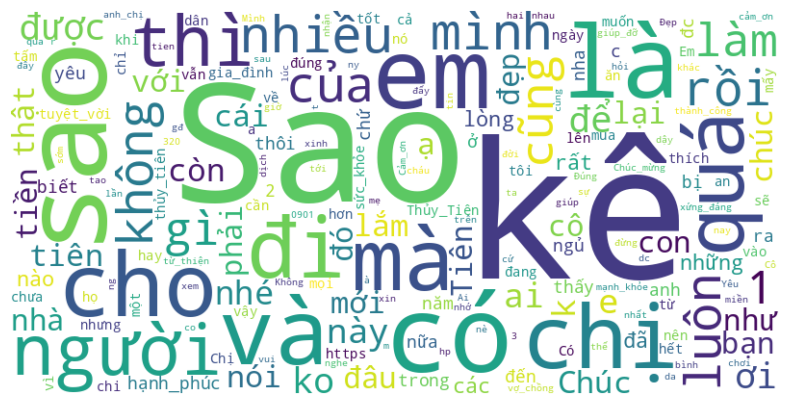

In [ ]:
# Tạo từ điển tần suất từ
word_freq = dict(zip(count_pandas_df ['word'], count_pandas_df ['count']))

# Tạo WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)

# Hiển thị WordCloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

**Biểu đồ thể hiện Top 20 từ ngữ được bình luận nhiều nhất trên Facebook**

In [ ]:
sorted_word_count_df_1 = counts_df.orderBy(desc('count'))
top_20_words_df_1 = sorted_word_count_df_1.limit(20)
top_20_words_pd_1 = top_20_words_df_1.toPandas()

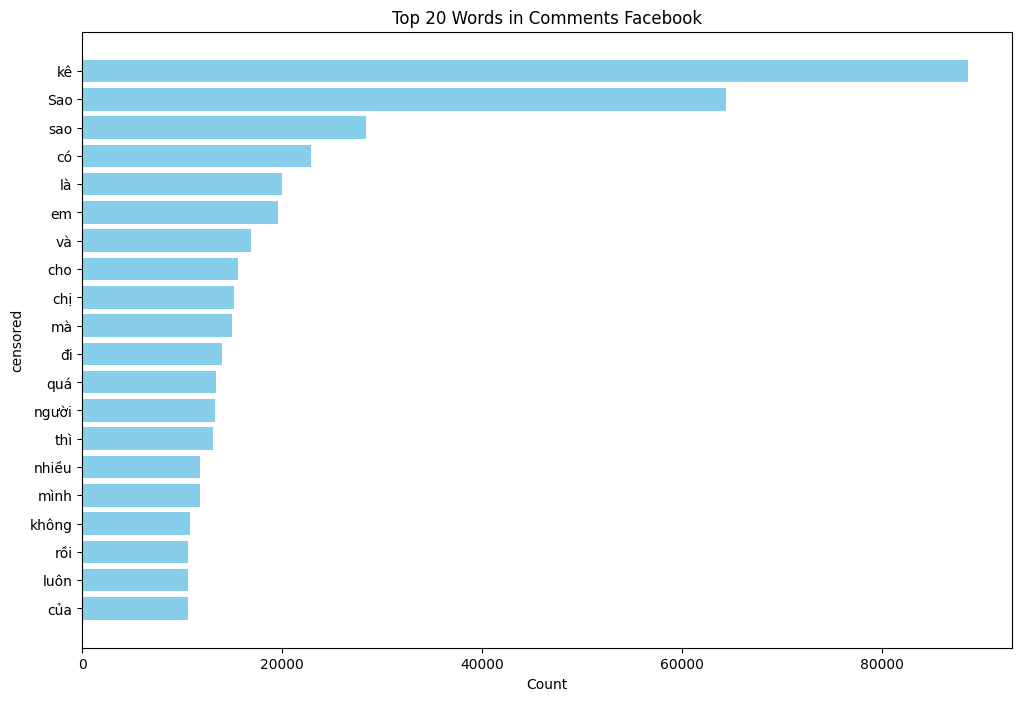

In [ ]:
# Vẽ biểu đồ thanh ngang (Bar Chart)
plt.figure(figsize=(12, 8))
plt.barh(top_20_words_pd_1['word'], top_20_words_pd_1['count'], color='skyblue')
plt.xlabel('Count')
plt.ylabel('censored')
plt.title('Top 20 Words in Comments Facebook')
plt.gca().invert_yaxis()  # Đảo ngược trục y để từ có tần suất cao nhất ở trên cùng
plt.show()

#**Phát hiện bình luận tiêu cực**

**Biến đổi file bình luận đã tiền xử lý**

In [ ]:
# Chuyển đổi textRDD trở lại thành DataFrame
# Chia các chuỗi văn bản thành các cột
rdd_split = textRDD2.map(lambda line: line.split(","))

# Xác định lược đồ cho DataFrame mới (nếu cần)
columns = csv_data.columns

# Tạo DataFrame từ rdd_split với lược đồ
comments_df = rdd_split.toDF(columns)

# Hiển thị DataFrame đã biến đổi
comments_df.show(truncate=False)

+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|comments                                                                                                                                                                 |
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|Thương chị Em tin chị Cảm_ơn chị Chúc vợ_chồng anh_chị thật nhiều sức_khỏe Những người phá_hoại họ sẽ bị trừng_phạt thôi Trả lại bình_yên cho xã_hội                     |
|Chuẩn rồi a tin em                                                                                                                                                       |
|End of season sale giảm 70 anh_em ơi                                                                                                       

**Phát hiện bình luận tiêu cực và xóa chúng**

In [ ]:
# Bước 1: Tạo SparkSession
spark = SparkSession.builder.appName("DetectNegativeComments").getOrCreate()

# Bước 2: Đọc danh sách từ ngữ tiêu cực từ file TXT
with open("/content/toxicword.txt", "r", encoding="utf-8") as f:
    negative_words = f.read().splitlines()

# Chuyển đổi danh sách từ ngữ tiêu cực thành regex pattern với ranh giới từ
negative_pattern = r'\b(' + '|'.join([re.escape(word) for word in negative_words]) + r')\b'

# Bước 3: Tạo hàm UDF để kiểm tra từ ngữ tiêu cực trong bình luận
def get_negative_word(comment):
    if comment is None:
        return None
    match = re.search(negative_pattern, comment, re.IGNORECASE)
    if match:
        return match.group(0)
    return None

# Đăng ký UDF
get_negative_word_udf = udf(get_negative_word, StringType())

# Áp dụng UDF để tạo cột đánh dấu bình luận tiêu cực
comments_df = comments_df.withColumn("negative_word", get_negative_word_udf(col("comments")))

# Bước 4: Báo cáo và xóa bình luận tiêu cực
# Báo cáo
negative_comments_df = comments_df.filter(col("negative_word").isNotNull()).select("comments", "negative_word")
negative_comments_df.show(truncate=False)

# Xóa bình luận tiêu cực
filtered_comments_df = comments_df.filter(col("negative_word").isNull())

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------+
|comments                                                                                                                                                                                                 |negative_word|
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------+
|Người_ta đã khổ_sở đi làm từ_thiện Những người đóng_góp họ ko kêu gì mấy người ko đóng_góp thì soi_mói bới_móc hãm                                                                                       |hãm          |
|Nói_chuyện thì phải vấp chứ tao nói với ba mẹ tao tao còn vấp huống_chi đứng trước nhiều người báo_chí ở đó mà kịch_bản mệt vl 

In [ ]:
# Hiển thị các bình luận không tiêu cực còn lại
filtered_comments_df.show(truncate=False)

+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------+
|comments                                                                                                                                                                 |negative_word|
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------+
|Thương chị Em tin chị Cảm_ơn chị Chúc vợ_chồng anh_chị thật nhiều sức_khỏe Những người phá_hoại họ sẽ bị trừng_phạt thôi Trả lại bình_yên cho xã_hội                     |NULL         |
|Chuẩn rồi a tin em                                                                                                                                                       |NULL         |
|End of season sale giảm 70 anh_em ơi                                 

# **Phân tích các bình luận tiêu cực**

## **WordCount**

In [ ]:
# Chuẩn hóa dữ liệu: Chuyển tất cả các từ trong cột 'negative_word' về chữ viết thường
negative_comments_df_1 = negative_comments_df.withColumn('negative_word', lower(negative_comments_df['negative_word']))

In [ ]:
# Tách các từ trong cột 'negative_word' và đếm tần suất
words_df = negative_comments_df_1.select(explode(split('negative_word', ' ')).alias('word'))

In [ ]:
# Đếm tần suất xuất hiện của từng từ
word_count_df = words_df.groupBy('word').count()
word_count_df = word_count_df.orderBy('count', ascending=False)

# Hiển thị kết quả
word_count_df.show()

+-----+-----+
| word|count|
+-----+-----+
|  đéo| 1054|
|  ngu|  581|
|   cu|  281|
|   vl|  260|
|   đm|  235|
|   mẹ|  188|
|  vãi|  152|
|   cl|  149|
|   dm|  129|
|  cac|  128|
|   kệ|  105|
|  vcl|  101|
|  deo|   80|
|  hãm|   73|
|  lol|   70|
| chết|   69|
|chịch|   65|
|   đĩ|   64|
|  cmn|   63|
|  sml|   51|
+-----+-----+
only showing top 20 rows



In [ ]:
# MÃ HÓA CÁC TỪ TOXIC

# Khởi tạo SparkSession
spark = SparkSession.builder.appName("WordCensorship").getOrCreate()

# Dữ liệu mẫu
data = word_count_df

# Hàm để làm mờ từ
def censor_word(word):
    if len(word) == 2:
        return word[0] + "*"
    elif len(word) >= 3:
        return word[0] + "*" * (len(word) - 2) + word[-1]
    else:
        return word

# UDF để áp dụng hàm censor_word
censor_word_udf = udf(censor_word, StringType())

# Áp dụng hàm làm mờ từ vào cột "word"
censored_df = word_count_df.withColumn("censored_word", censor_word_udf(col("word")))

# Hiển thị kết quả
censored_df.show()

+-----+-----+-------------+
| word|count|censored_word|
+-----+-----+-------------+
|  đéo| 1054|          đ*o|
|  ngu|  581|          n*u|
|   cu|  281|           c*|
|   vl|  260|           v*|
|   đm|  235|           đ*|
|   mẹ|  188|           m*|
|  vãi|  152|          v*i|
|   cl|  149|           c*|
|   dm|  129|           d*|
|  cac|  128|          c*c|
|   kệ|  105|           k*|
|  vcl|  101|          v*l|
|  deo|   80|          d*o|
|  hãm|   73|          h*m|
|  lol|   70|          l*l|
| chết|   69|         c**t|
|chịch|   65|        c***h|
|   đĩ|   64|           đ*|
|  cmn|   63|          c*n|
|  sml|   51|          s*l|
+-----+-----+-------------+
only showing top 20 rows



In [ ]:
# Lấy hai cột "censored_word" và "count"
result_df = censored_df.select(col("censored_word").alias("censored"), col("count"))

# Hiển thị kết quả
result_df.show(truncate=False)

+--------+-----+
|censored|count|
+--------+-----+
|đ*o     |1054 |
|n*u     |581  |
|c*      |281  |
|v*      |260  |
|đ*      |235  |
|m*      |188  |
|v*i     |152  |
|c*      |149  |
|d*      |129  |
|c*c     |128  |
|k*      |105  |
|v*l     |101  |
|d*o     |80   |
|h*m     |73   |
|l*l     |70   |
|c**t    |69   |
|c***h   |65   |
|đ*      |64   |
|c*n     |63   |
|s*l     |51   |
+--------+-----+
only showing top 20 rows



In [ ]:
# Chuyển đổi DataFrame từ PySpark sang Pandas
pandas_df = result_df.toPandas()

# Chuyển đổi kết quả về Pandas DataFrame
word_count_pd = word_count_df.toPandas()

In [ ]:
# Tạo từ điển tần suất từ
word_freq = dict(zip(pandas_df ['censored'], pandas_df ['count']))

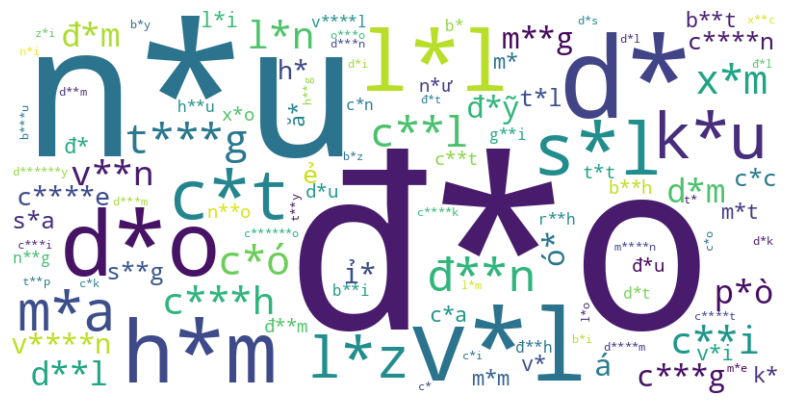

In [ ]:
# Tạo WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)

# Hiển thị WordCloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## **Biểu đồ**

**Lấy top 20 từ ngữ toxic được bình luận nhiều nhất**

In [ ]:
# Sắp xếp DataFrame theo cột 'count' theo thứ tự giảm dần
sorted_word_count_df = result_df.orderBy(desc('count'))

# Lấy top 20 từ
top_20_words_df = sorted_word_count_df.limit(20)

# Hiển thị kết quả
top_20_words_df.show()

+--------+-----+
|censored|count|
+--------+-----+
|     đ*o| 1054|
|     n*u|  581|
|      c*|  281|
|      v*|  260|
|      đ*|  235|
|      m*|  188|
|     v*i|  152|
|      c*|  149|
|      d*|  129|
|     c*c|  128|
|      k*|  105|
|     v*l|  101|
|     d*o|   80|
|     h*m|   73|
|     l*l|   70|
|    c**t|   69|
|   c***h|   65|
|      đ*|   64|
|     c*n|   63|
|     s*l|   51|
+--------+-----+



In [ ]:
# Hiển thị Top 20 từ ngữ tiêu cực
top_20_words_pd = top_20_words_df.toPandas()
print(top_20_words_pd)

   censored  count
0       đ*o   1054
1       n*u    581
2        c*    281
3        v*    260
4        đ*    235
5        m*    188
6       v*i    152
7        c*    149
8        d*    129
9       c*c    128
10       k*    105
11      v*l    101
12      d*o     80
13      h*m     73
14      l*l     70
15     c**t     69
16    c***h     65
17       đ*     64
18      c*n     63
19      s*l     51


In [ ]:
# Hiển thị tất cả các từ ngữ tiêu cực
All_negative_words = sorted_word_count_df.toPandas()
All_negative_words.head()

,censored,count
0,đ*o,1054
1,n*u,581
2,c*,281
3,v*,260
4,đ*,235


**Biểu đồ**

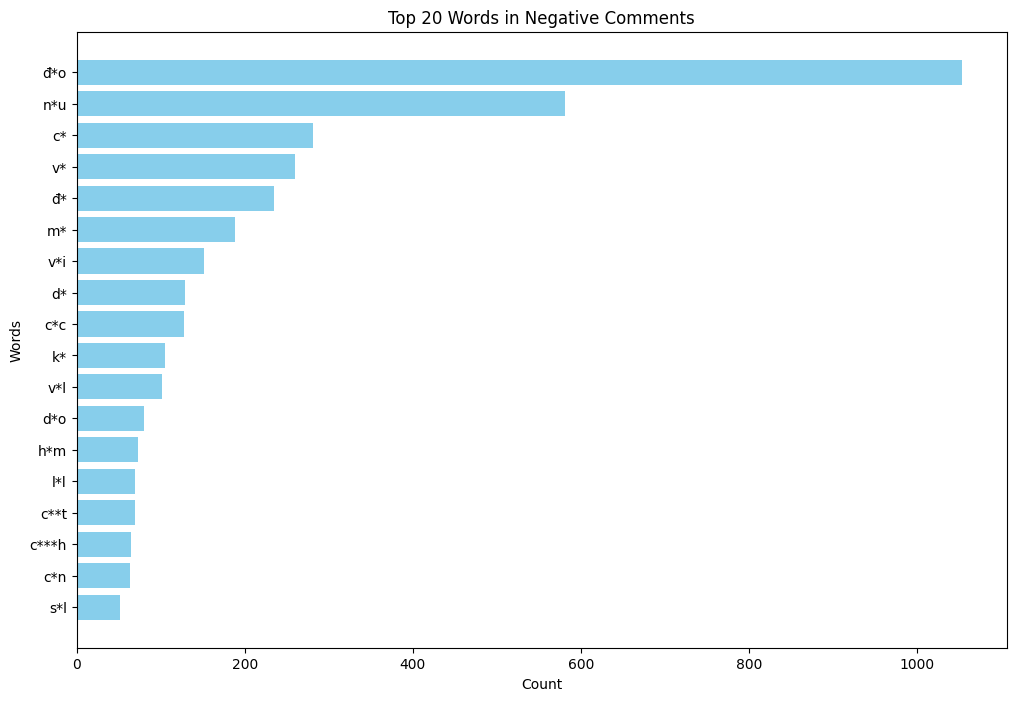

In [ ]:
# Sử dụng DataFrame top_20_words_pd: Bar Chart
plt.figure(figsize=(12, 8))
plt.barh(top_20_words_pd['censored'], top_20_words_pd['count'], color='skyblue')
plt.xlabel('Count')
plt.ylabel('Words')
plt.title('Top 20 Words in Negative Comments')
plt.gca().invert_yaxis()  # Đảo ngược trục y để từ có tần suất cao nhất ở trên cùng
plt.show()

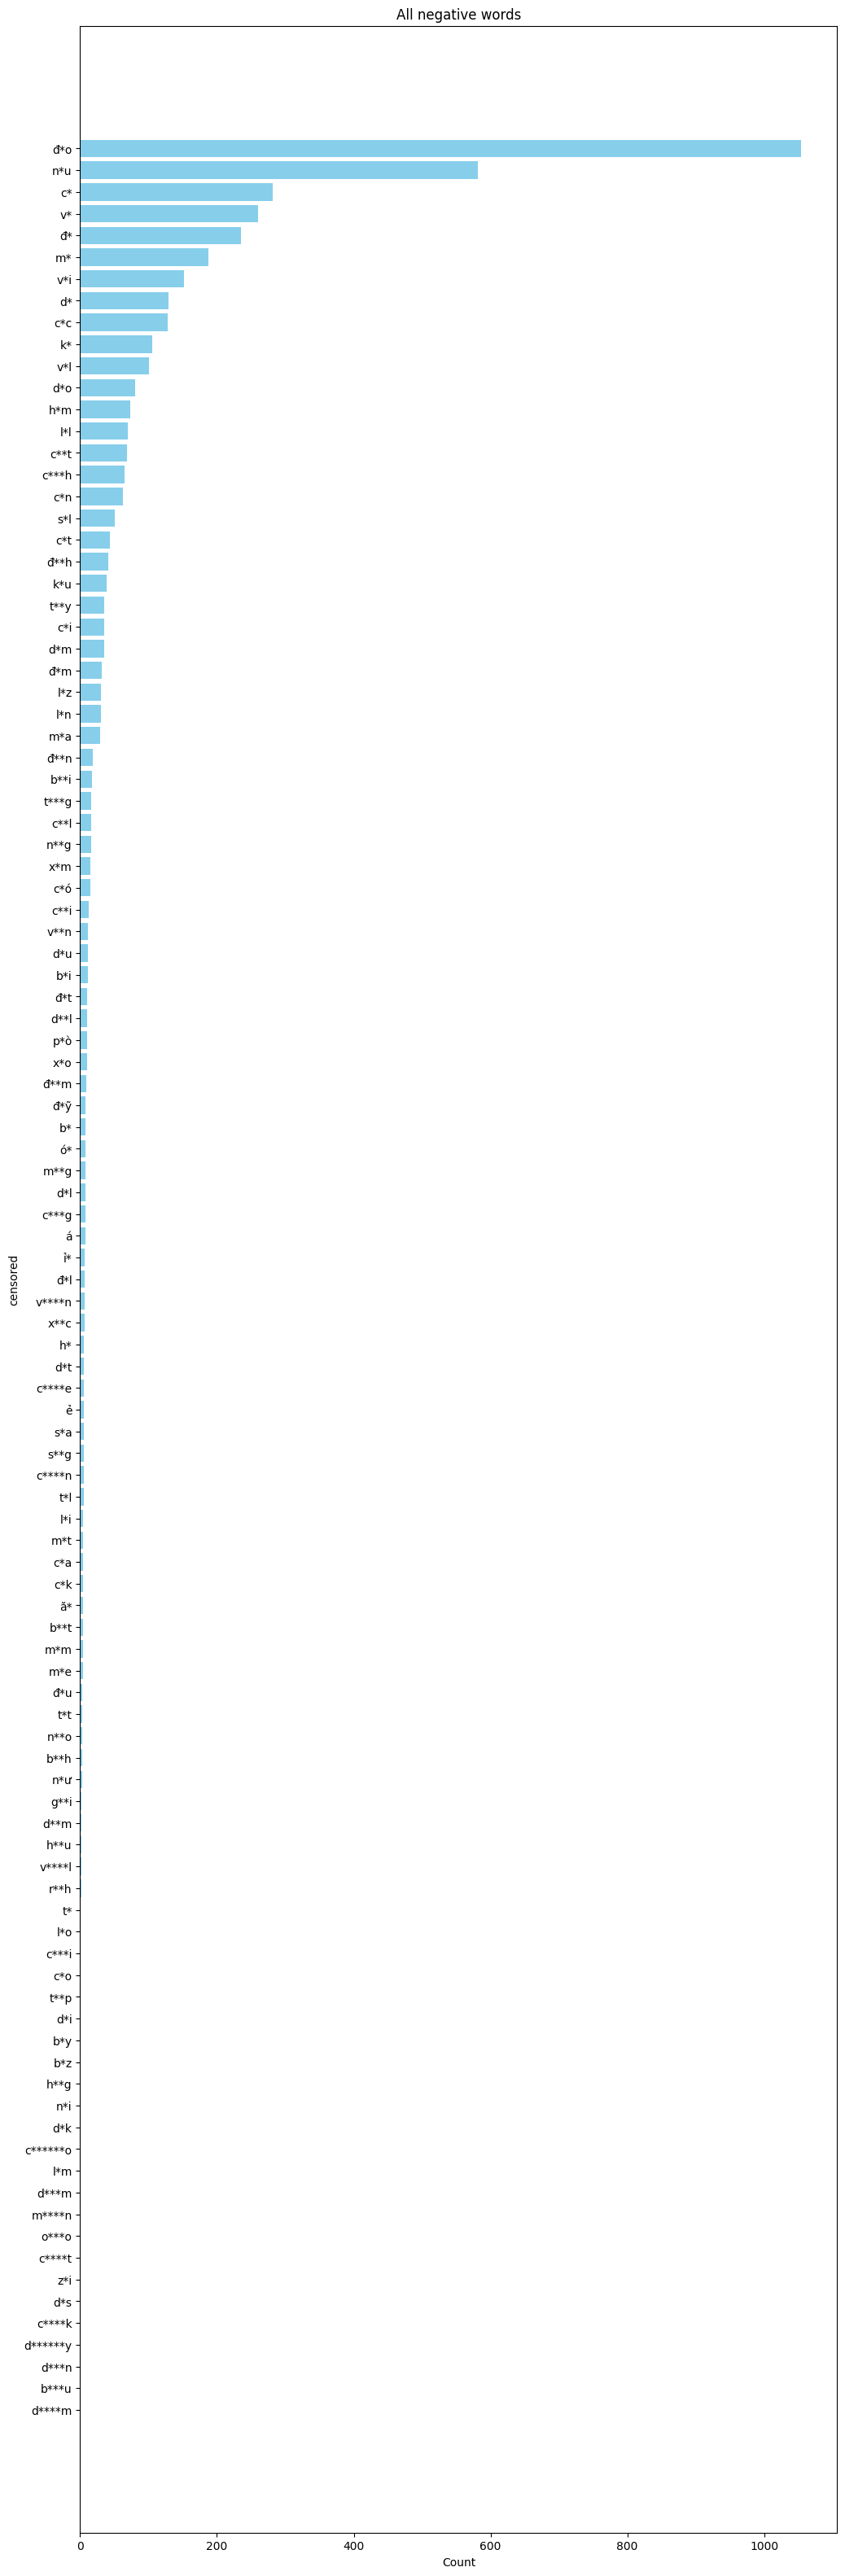

In [ ]:
# Sử dụng DataFrame All_negative_words: Bar Chart
plt.figure(figsize=(12, 40))
plt.barh(All_negative_words['censored'], All_negative_words['count'], color='skyblue')
plt.xlabel('Count')
plt.ylabel('censored')
plt.title('All negative words')
plt.gca().invert_yaxis()  # Đảo ngược trục y để từ có tần suất cao nhất ở trên cùng
plt.show()

In [ ]:
# Sử dụng DataFrame top_20_words_pd: Pie Chart
import altair as alt
chart = alt.Chart(top_20_words_pd).mark_arc().encode(
    theta=alt.Theta(field="count", type="quantitative"),
    color=alt.Color(field="censored", type="nominal"),
).properties(
    width=500,
    height=300,
)
chart

alt.Chart(...)

In [ ]:
# Sử dụng DataFrame All_nagative_words: Pie Chart
chart = alt.Chart(All_negative_words).mark_arc().encode(
    theta=alt.Theta(field="count", type="quantitative"),
    color=alt.Color(field="censored", type="nominal"),
).properties(
    width=500,
    height=300,
)
chart

alt.Chart(...)

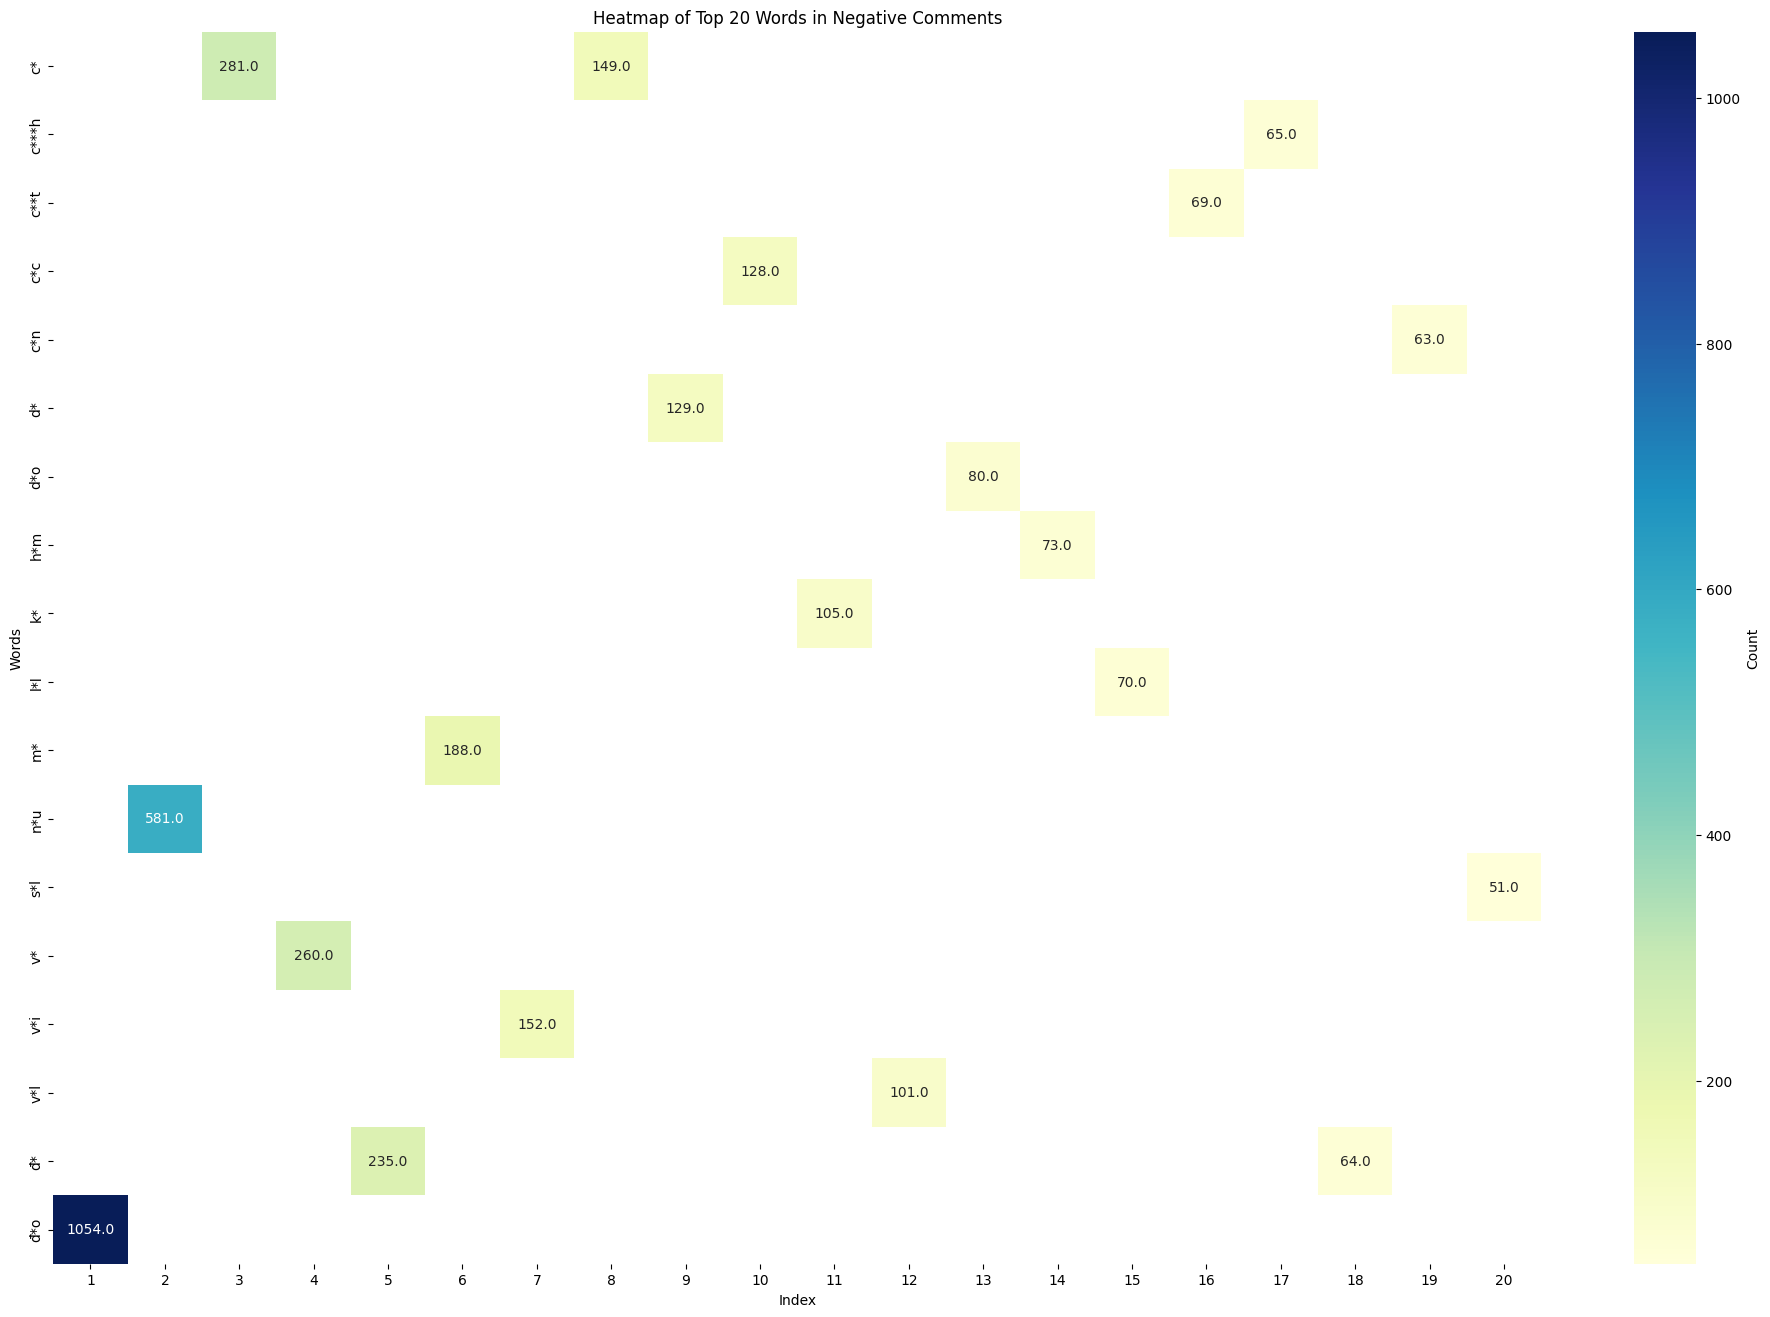

In [ ]:
# Tạo một trục x giả để tạo heatmap
top_20_words_pd['index'] = range(1, len(top_20_words_pd) + 1)

# Tạo một Pivot Table để dùng cho heatmap
heatmap_data = pd.pivot_table(top_20_words_pd, values='count', index='censored', columns='index')

# Vẽ heatmap
plt.figure(figsize=(24, 16))
sns.heatmap(heatmap_data, annot=True, fmt=".1f", cmap="YlGnBu", cbar_kws={'label': 'Count'})
plt.title('Heatmap of Top 20 Words in Negative Comments')
plt.xlabel('Index')
plt.ylabel('Words')
plt.show()

# **Không cho phép đăng bình luận tiêu cực**

In [ ]:
# Liên tục nhận và kiểm tra bình luận từ người dùng
while True:
    user_comment = input("Nhập bình luận của bạn (hoặc nhập 'exit' để thoát): ")

    if user_comment.lower() == 'exit':
        break

    # Tạo DataFrame chứa bình luận của người dùng
    user_comment_df = spark.createDataFrame([(user_comment,)], ["comment"])

    # Áp dụng UDF để kiểm tra bình luận tiêu cực
    user_comment_df = user_comment_df.withColumn("negative_word", get_negative_word_udf(col("comment")))

    # Kiểm tra và thông báo kết quả
    is_negative = user_comment_df.collect()[0]["negative_word"]

    if is_negative:
        print("Bình luận của bạn chứa nội dung tiêu cực và đã bị xóa.")
    else:
        print("Bình luận của bạn đã đăng thành công.")

Nhập bình luận của bạn (hoặc nhập 'exit' để thoát): Ngu vua thoi.
Bình luận của bạn chứa nội dung tiêu cực và đã bị xóa.
Nhập bình luận của bạn (hoặc nhập 'exit' để thoát): Toi yeu ban lam
Bình luận của bạn đã đăng thành công.
Nhập bình luận của bạn (hoặc nhập 'exit' để thoát): exit


# **Dừng Spark**

In [ ]:
spark.stop()